In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import json
import os 

In [2]:
def nose_steps():

    path = '../code/NOSE_results.json'

    # DIffernces
    # - addd 2 * x in hidden state
    # - using the avarege of 10 samples

    with open(path) as f:
        data = json.load(f)


    te_matrix = np.zeros((len(data.keys()), 32))

    for i, (key, value) in enumerate(data.items()):
        for j, (k, v) in enumerate(data[key]['transfer_entropy'].items()):
            te_matrix[i, int(k)] = v


    plt.figure(figsize=(15, 6))

    sns.lineplot(data=pd.DataFrame(te_matrix).T, dashes=True, linewidth=2)
    plt.axhline(0, color='black', linestyle='-', linewidth=0.5)
    plt.xlabel('Attention Layer Index') 
    plt.ylabel('Transfer Entropy')
    leg = plt.legend(title='Steps', loc='upper left', fontsize=13)
    leg._legend_box.align = "left"
    plt.title('Transfer Entropy between Attention Layers and last layer')


    plt.show()


def nose_summary():

    path = '../code/NOSE_results.json'

    with open(path) as f:
        data = json.load(f)

    num_layers = 32
    steps = list(data.keys())
    columns = np.arange(num_layers)

    matrix = np.zeros((len(steps), len(columns)))
    results_line = np.zeros(num_layers)

    for i, step in enumerate(steps):
        line = [data[step]['transfer_entropy'].get(str(col), np.nan) for col in columns]
        min_line, max_line = np.nanmin(line), np.nanmax(line)
        values = [(x - min_line) / (max_line - min_line) for x in line]
        matrix[i, :] = values

    for i, value in enumerate(matrix[-1, :]):
        if np.isnan(value) or value == 0:
            results_line[i] = np.nan
        else:
            results_line[i] = 0


    # Create the plot
    plt.figure(figsize=(15, 6))

    matrix = np.vstack((matrix, np.zeros(num_layers)))
    matrix = np.vstack((matrix, results_line))
    labels = [f'Step {i}' for i in range(len(data.keys()))] + ['', 'Result']

    cbar_kws=dict(pad=0.03, shrink=0.8)

    sns.heatmap(matrix, annot=False, cmap='YlGnBu', cbar=True, vmin=0, vmax=1, linewidths=1, cbar_kws=cbar_kws)
    plt.yticks(np.arange(len(steps)+2)+0.5, labels=labels, rotation=0)
    plt.tick_params(axis='x', which='both', top=True, labeltop=True, bottom=False, labelbottom=False)
    plt.tick_params(axis='both', which='both', length=0)
    plt.tick_params(axis='y', which='both', length=0, pad=8)
    plt.title('Index of Attn Layer', loc='center', pad=30, size=11)



    for y in range(matrix.shape[1]):
        if matrix[-2, y] == 0:
            plt.gca().add_patch(plt.Rectangle((y, matrix.shape[0]-2), 1, 1, fill=True, color='white', linestyle='-', linewidth=1.5))

    for y in range(matrix.shape[1]):
        if matrix[-1, y] == 0:
            plt.gca().add_patch(plt.Rectangle((y, matrix.shape[0]-1), 1, 1, fill=True, edgecolor='white', linestyle='-', linewidth=1.5))

    for x in range(matrix.shape[0]):
        for y in range(matrix.shape[1]):
            if matrix[x, y] == 0 and x != matrix.shape[0] - 1 and x != matrix.shape[0] - 2:
                plt.gca().add_patch(plt.Rectangle((y, x), 1, 1, fill=False, edgecolor='red', linestyle='--', linewidth=1.5))
            if np.isnan(matrix[x, y]):
                plt.gca().add_patch(plt.Rectangle((y+0.06, x+0.05), .9, .9, fill=False, hatch='...', edgecolor='grey', linestyle='-', linewidth=0))

    plt.show()


def training_records():

    results_dir = '../code/training/results'

    folders = [f for f in os.listdir(results_dir) if os.path.isdir(os.path.join(results_dir, f))]

    num_folders = len(folders)
    num_cols = 3  
    num_rows = (num_folders + num_cols - 1) // num_cols  

    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

    axes = axes.flatten()

    for idx, folder in enumerate(folders):
        try:
            file_path = os.path.join(results_dir, folder, 'epochs_metrics.json')
            
            if os.path.exists(file_path):
                with open(file_path, 'r') as f:
                    data = json.load(f)
                
                train_loss, val_loss = [], []
                
                for epoch in data:
                    epoch_results = data[epoch]
                    train_loss.append(epoch_results['train_loss'])
                    val_loss.append(epoch_results['val_loss'])
                
                ax = axes[idx]
                ax.plot(train_loss, label='train')
                ax.plot(val_loss, label='val')
                ax.set_ylim(0.2, 1)
                ax.set_title(f'Loss Metrics for {folder}')
                ax.set_xlabel('Epoch')
                ax.set_ylabel('Loss')
                ax.legend()
            else:
                print(f"Warning: File {file_path} not found. Skipping.")
        except Exception as e:
            print(f"Error processing {file_path}: {e}")

    for idx in range(num_folders, num_rows * num_cols):
        fig.delaxes(axes[idx])

    plt.tight_layout()
    plt.show()


def results_df():
    columns = ['model', 'flops', 'parameters', 'memory', 'BLUE', 'CB', 'CA']
    columns_units = ['Model', 'Flops (B)', 'Parameters (B)', 'Memory (GB)', 'BLUE', 'CB', 'CA']
    df = pd.DataFrame(columns=columns)

    folders = os.listdir('../results')

    for i, folder in enumerate(folders):
        file_path = '../results/' + folder + '/metrics.json'
        with open(file_path, 'r') as f:
            data = json.load(f)
            data['model'] = folder
            df.loc[i] = data



    df['flops'] = df['flops'] / 1e9
    df['parameters'] = df['parameters'] / 1e9
    df['memory'] = df['memory'] / 1024**3

    df = df.map(lambda x: round(x, 2) if isinstance(x, (int, float)) else x)

    df.columns = columns_units

    df.set_index('Model', inplace=True)


    return df

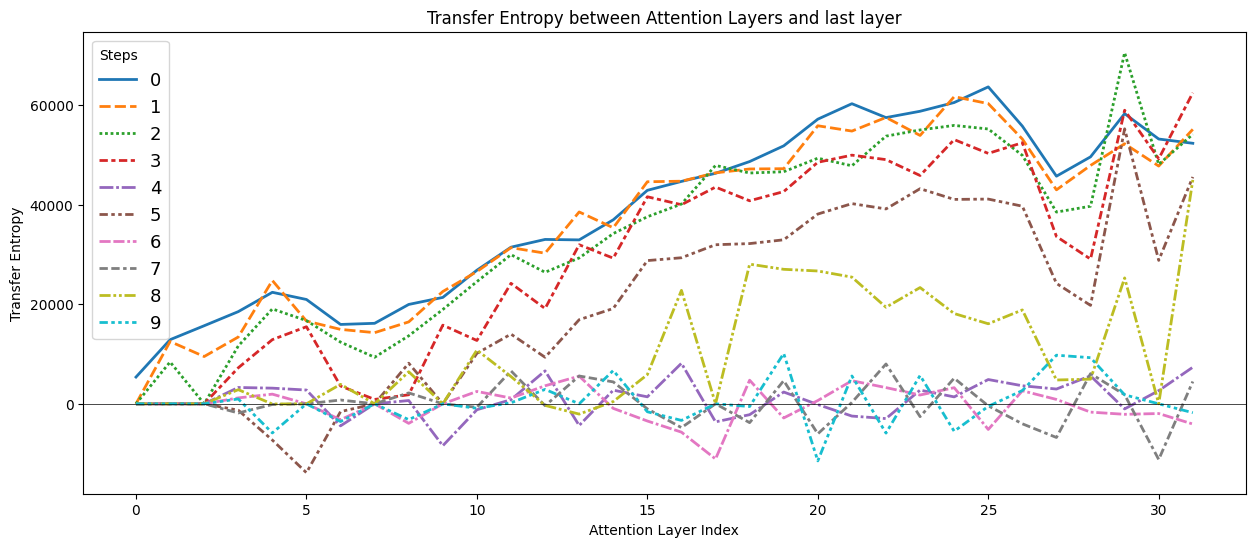

In [3]:
nose_steps()

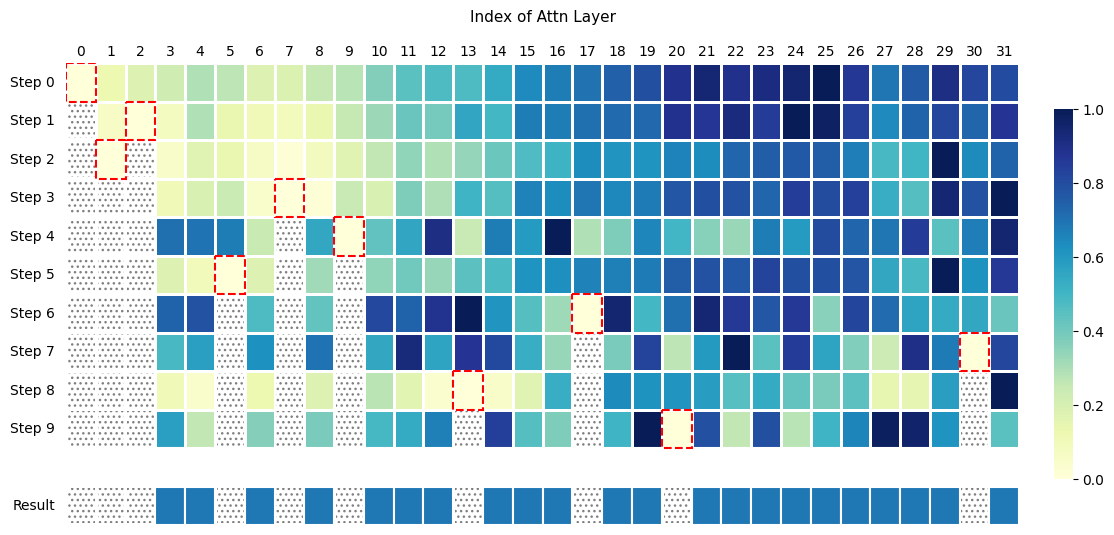

In [9]:
nose_summary()

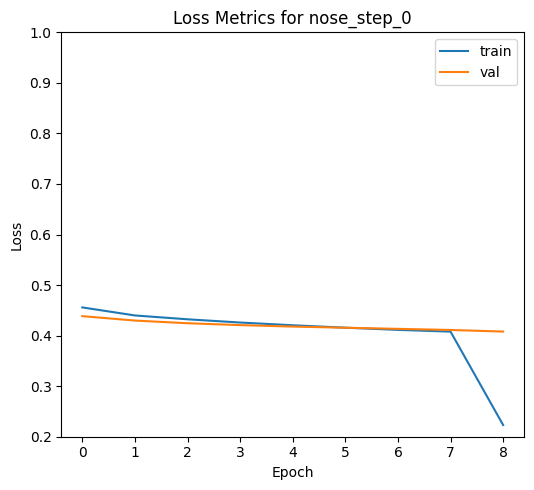

In [10]:
training_records()

In [4]:
results_df()

,Flops (B),Parameters (B),Memory (GB),BLUE,CB,CA
Model,,,,,,
baseline,6766.72,6.74,12.56,0.7,0.77,0.93
nose_step_0,6698.00,6.67,12.43,0.7,0.76,0.86
